In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

% matplotlib inline

In [159]:
#Read the data set
loan_df= pd.read_csv('loan.csv', low_memory=False)
dictionaries_df = pd.read_excel('Data_Dictionary.xlsx')

In [160]:
dictionaries_df.columns

Index(['LoanStatNew', 'Description'], dtype='object')

In [161]:
def getColumnDescription(columnNames):
    temp = dictionaries_df[columnNames]

In [162]:
# Get the same of data set
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [163]:
#Check if any of the columns have total null rows
loan_df.isna().all()

id                                False
member_id                         False
loan_amnt                         False
funded_amnt                       False
funded_amnt_inv                   False
term                              False
int_rate                          False
installment                       False
grade                             False
sub_grade                         False
emp_title                         False
emp_length                        False
home_ownership                    False
annual_inc                        False
verification_status               False
issue_d                           False
loan_status                       False
pymnt_plan                        False
url                               False
desc                              False
purpose                           False
title                             False
zip_code                          False
addr_state                        False
dti                               False


In [164]:
# Get the number of rows that have all rows as null
loan_df.isna().all().sum()

54

In [165]:
# Drop the columns that that have all NaN rows
loan_df.dropna(axis=1, how='all', inplace=True)

In [166]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
id                            39717 non-null int64
member_id                     39717 non-null int64
loan_amnt                     39717 non-null int64
funded_amnt                   39717 non-null int64
funded_amnt_inv               39717 non-null float64
term                          39717 non-null object
int_rate                      39717 non-null object
installment                   39717 non-null float64
grade                         39717 non-null object
sub_grade                     39717 non-null object
emp_title                     37258 non-null object
emp_length                    38642 non-null object
home_ownership                39717 non-null object
annual_inc                    39717 non-null float64
verification_status           39717 non-null object
issue_d                       39717 non-null object
loan_status                   39717 non-null object
pymnt_pl

In [167]:
loan_df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_

##### First we need to understand which of the columns needs to be retained

In [168]:
# Drop irrelavant columns such as id, desc, url, title
# id = A unique LC assigned ID for the loan listing.
# desc = Loan description provided by the borrower
# url = URL for the LC page with listing data.

loan_df.drop(columns=['id', 'url', 'desc'], inplace=True)

In [169]:
# we will drop emp_title
loan_df.drop(columns='emp_title', inplace=True)

In [170]:
# We will drop the title
loan_df.drop(columns='title', inplace=True)

In [171]:
loan_df.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

### Univariate Ananlysis

In [173]:
#Which year issued the most loans. Formats from http://strftime.org/
loan_df['loan_issue_year'] = pd.to_datetime(loan_df['issue_d'], format='%b-%y').dt.year

In [174]:
loan_df['loan_issue_year']

0        2011
1        2011
2        2011
3        2011
4        2011
5        2011
6        2011
7        2011
8        2011
9        2011
10       2011
11       2011
12       2011
13       2011
14       2011
15       2011
16       2011
17       2011
18       2011
19       2011
20       2011
21       2011
22       2011
23       2011
24       2011
25       2011
26       2011
27       2011
28       2011
29       2011
         ... 
39687    2007
39688    2007
39689    2007
39690    2007
39691    2007
39692    2007
39693    2007
39694    2007
39695    2007
39696    2007
39697    2007
39698    2007
39699    2007
39700    2007
39701    2007
39702    2007
39703    2007
39704    2007
39705    2007
39706    2007
39707    2007
39708    2007
39709    2007
39710    2007
39711    2007
39712    2007
39713    2007
39714    2007
39715    2007
39716    2007
Name: loan_issue_year, Length: 39717, dtype: int64

Text(0,0.5,'Loan Amount')

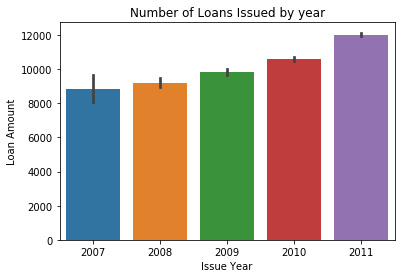

In [175]:
sns.barplot(x='loan_issue_year', y='loan_amnt', data=loan_df)
plt.title("Number of Loans Issued by year")
plt.xlabel("Issue Year")
plt.ylabel("Loan Amount")